In [1]:
import os
os.environ['NUMBA_DISABLE_JIT'] = "1"

import numpy as np
from scipy import constants
from PyMPDATA import (Solver, Stepper, Options, ScalarField, VectorField,
                      ExtrapolatedBoundaryCondition, ConstantBoundaryCondition)
from matplotlib import pyplot
from PyMPDATA_examples.Shipway_and_Hill_2012 import Settings, Formulae, si, arakawa_c, const, plot
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import pylab

In [2]:
f = Formulae()

In [3]:
# note: 1=bulk
nrs=(16,)

In [4]:
def repeat_in_r(vec, nr):
    return np.repeat(vec.reshape(-1,1), nr, axis=1).squeeze()

def label(w, nr):
    return f"nr={nr}_w={w}"

In [5]:
class MPDATA:
    def __init__(self, nz, dt, qv_of_zZ_at_t0, g_factor_of_zZ, mpdata_settings, nr):
        self.t = 0
        self.dt = dt
        self.fields = ('qv', 'ql')

        options = Options(
            n_iters=mpdata_settings['n_iters'],
            infinite_gauge=mpdata_settings['iga'],
            flux_corrected_transport=mpdata_settings['fct'],
            third_order_terms=mpdata_settings['tot'],
            
        )
        
        self._solvers = {}
        for k in self.fields:
            grid = (nz, nr) if nr>1 and k =='ql' else (nz,)
            stepper = Stepper(options=options, grid=grid, non_unit_g_factor=True, n_threads=1)

            data = g_factor_of_zZ(arakawa_c.z_scalar_coord(grid)) 
            if nr > 1 and k == 'ql':
                data = repeat_in_r(data, nr)
            g_factor = ScalarField(
                data=data,
                halo=options.n_halo,
                boundary_conditions=(ConstantBoundaryCondition(np.nan),)*len(data.shape)  # TODO: Extrapolated
            )
            
            if nr == 1 or k == 'qv':
                data = (np.zeros(nz+1),)
            else:
                data = (np.zeros((nz+1, nr)), np.zeros((nz, nr+1)))
            advector = VectorField(
                data=data, 
                halo=options.n_halo,
                boundary_conditions=(ConstantBoundaryCondition(np.nan),)*len(data)  # TODO: Extrapolated
                )
            
            if k == 'qv':
                data = qv_of_zZ_at_t0(arakawa_c.z_scalar_coord(grid))
                bcs = (ConstantBoundaryCondition(value = data[0]),)
            else:
                data = np.zeros(grid)
                if nr == 1:
                    bcs = (ConstantBoundaryCondition(value=0),)
                else:
                    bcs = (ConstantBoundaryCondition(value=0), ConstantBoundaryCondition(100/si.mg/settings.dr))
            advectee = ScalarField(
                data=data,
                halo=options.n_halo,
                boundary_conditions=bcs
            )
            self._solvers[k] = Solver(stepper=stepper, advectee=advectee, advector=advector, g_factor=g_factor)
            
    def __getitem__(self, k):
        return self._solvers[k]


Simulating using nr=16:


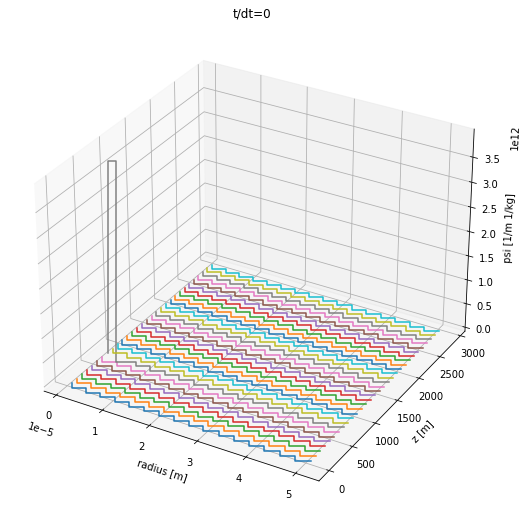

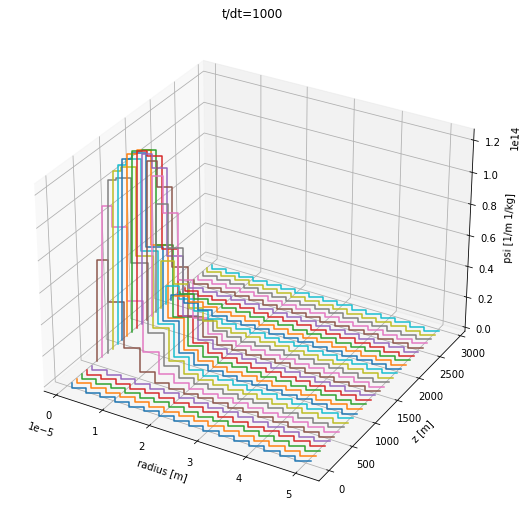

Simulating using nr=16:


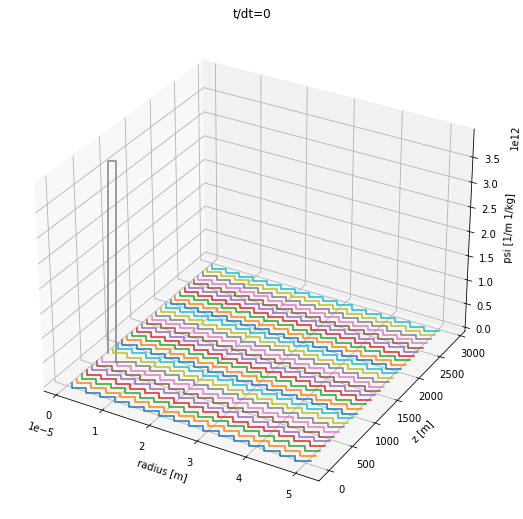

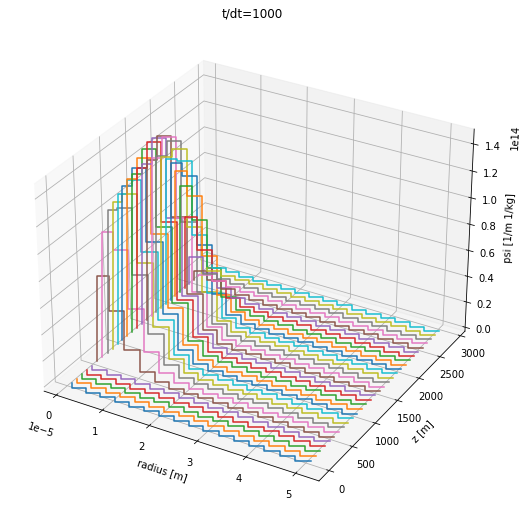

In [8]:
outputs = {}
for w in (2*si.m/si.s, 3*si.m/si.s):
    for nr in nrs:
        print("Simulating using nr={}:".format(nr))
        
        settings = Settings(w_1=w, nr=nr, dt=.5*si.s, dz=100*si.m, t_max=15*si.minutes)
        
        mpdata = MPDATA(
            nr=nr,
            nz=settings.nz, 
            dt=settings.dt, 
            mpdata_settings = settings.mpdata_settings,
            qv_of_zZ_at_t0 = lambda zZ: settings.qv(zZ*settings.dz),
            g_factor_of_zZ = lambda zZ: settings.rhod(zZ*settings.dz) # TODO #221 spectral coord
        )

        output = {k: np.zeros((settings.nz, settings.nt+1)) for k in ('qv', 'S', 'ql')}
     
        assert 't' not in output and 'z' not in output
        output['t'] = np.linspace(0, settings.nt*settings.dt, settings.nt+1, endpoint=True)
        output['z'] = np.linspace(settings.dz/2, (settings.nz-1/2)*settings.dz, settings.nz, endpoint=True)
        output['qv'][:,0] = mpdata['qv'].advectee.get()
        output['ql'][:,0] = 0

        prof = {}
        prof['rhod'] = settings.rhod(output['z'])
        prof['T'] = Formulae.T(prof['rhod'], settings.thd(output['z']))
        prof['p'] = Formulae.p(prof['rhod'], prof['T'], output['qv'][:,0])
        prof['pvs'] = Formulae.pvs_Celsius(prof['T']-const.T0)

        Gvec = settings.rhod(settings.z_vec)
        Gscl = prof['rhod']

        for t in range(settings.nt):
            C = settings.w((t+.5) * settings.dt) * settings.dt / settings.dz
            advector_0 = Gvec * C
            mpdata['qv'].advector.get_component(0)[:] = advector_0
            mpdata['qv'].advance(1)

            qv = mpdata['qv'].advectee.get()
            RH = Formulae.pv(prof['p'], qv) / prof['pvs']

            if nr==1:
                mpdata['ql'].advector.get_component(0)[:] = advector_0
                mpdata['ql'].advance(1)
            else:
                GC_max = [np.nan, np.nan]
                mpdata['ql'].advector.get_component(1)[:, :] = 0
                mpdata['ql'].advector.get_component(0)[:, :] = np.repeat(advector_0.reshape(1,-1).T, nr, axis=1)
                GC_max[0] = np.amax(mpdata['ql'].advector.get_component(0)[:,:])
                if GC_max[0] > 1:
                    raise Exception(f"max(GC) = {GC_max[0]} > 1")
                mpdata['ql'].advance(1)


                mpdata['ql'].advector.get_component(1)[:, :] = (
                    # scalar
                    settings.ksi_1 * settings.dt / settings.dr # m2/s * s / m
                    # column
                    * np.repeat((Gscl * (np.maximum(1, RH)-1)).reshape(1,-1).T, nr+1, axis=1) # kg/m3
                    # spectrum
                    / np.repeat(settings.bin_boundaries.reshape(1,-1), settings.nz, axis=0) # m-1       
                )
                mpdata['ql'].advector.get_component(0)[:, :] = 0
                GC_max[1] = np.amax(mpdata['ql'].advector.get_component(1)[:,:])
                if GC_max[1] > 1:
                    raise Exception(f"max(GC) = {GC_max[1]} > 1")

                psi = mpdata['ql'].advectee.get()
                ql_old = 4/3*np.pi*const.rho_l*np.sum(np.dot(psi, settings.dr4/4), axis=1)
                mpdata['ql'].advance(1)

            if nr==1:
                ql = mpdata['ql'].advectee.get()


                # TODO #221: iterate
                # TODO #221: assert not np.logical_and(S<1, ql>0).any()
                dql = np.maximum(0, qv * (1 - 1/RH))
                ql += dql
            else:
                
                # note: 4=l+1
                ql_new = 4/3*np.pi*const.rho_l*np.sum(np.dot(psi, settings.dr4/4), axis=1)
                if GC_max[1] > 0 and t % 1000 == 0:
                    pylab.figure(figsize=(15,9))
                    ax = pylab.subplot(projection='3d')
                    for z in range(settings.nz):
                        ax.step(
                            settings.bin_boundaries, 
                            np.ones(len(settings.bin_boundaries)) * z * settings.dz, 
                            np.concatenate(([0], psi[z,:])),
                            where='pre'
                        )
                    ax.set_title(f"t/dt={t}")
                    ax.set_xlabel("radius [m]")
                    ax.set_ylabel("z [m]")
                    ax.set_zlabel("psi [1/m 1/kg]")
                    pylab.show()
                    
                    # advection/conservation of n/V, but G_factor=G_z*G_r=rho(z)*1, so psi=n/V/rho
                    
                dql = ql_new - ql_old

            qv -= dql

            output['ql'][:,t+1] = ql_new    
            output['qv'][:,t+1] = qv
            output['S'][:,t+1] = RH - 1
            
        outputs[label(w, nr)] = output

Plotting results for nr 16:
plotting line at=180.0
plotting line at=360.0
plotting line at=540.0
plotting line at=720.0


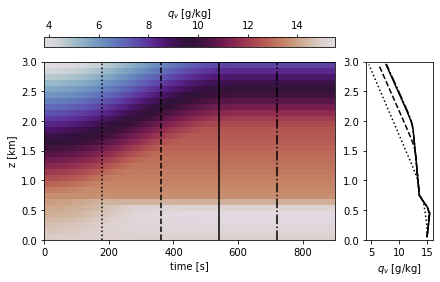

plotting line at=180.0
plotting line at=360.0
plotting line at=540.0
plotting line at=720.0


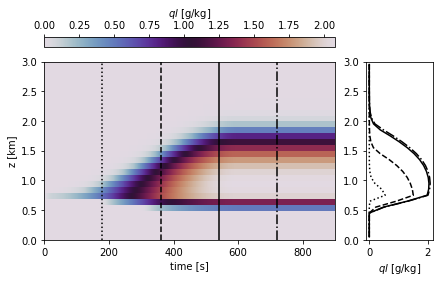

plotting line at=180.0
plotting line at=360.0
plotting line at=540.0
plotting line at=720.0


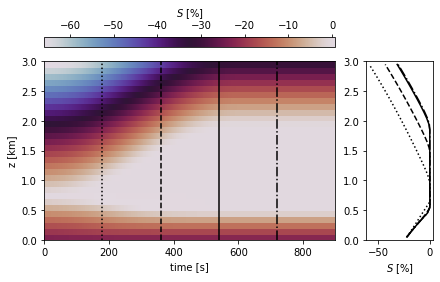

plotting line at=180.0
plotting line at=360.0
plotting line at=540.0
plotting line at=720.0


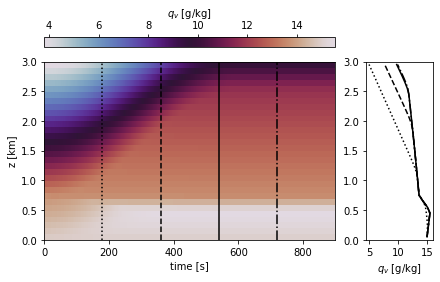

plotting line at=180.0
plotting line at=360.0
plotting line at=540.0
plotting line at=720.0


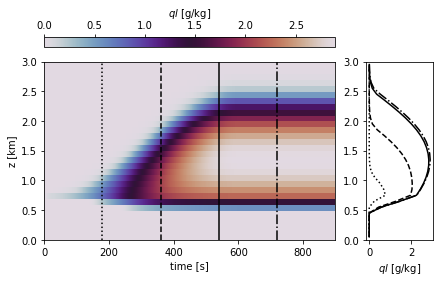

plotting line at=180.0
plotting line at=360.0
plotting line at=540.0
plotting line at=720.0


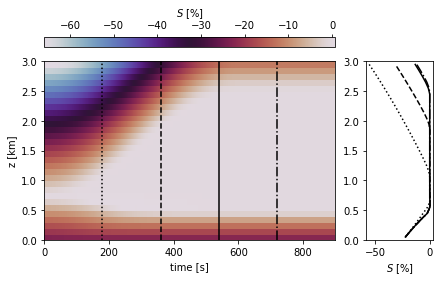

In [9]:
for nr in nrs:
    print("Plotting results for nr {}:".format(nr))
    for w in (2, 3):
        key = label(w, nr)
        plot(var='qv', mult=1e3, qlabel='$q_v$ [g/kg]', fname=f'qv_{key}.pdf', output=outputs[f'{key}.0'])
        pyplot.show()
        plot(var='ql', mult=1e3, qlabel='$ql$ [g/kg]', fname=f'ql_{w}.pdf', output=outputs[f'{key}.0'])
        pyplot.show()
        plot(var='S', mult=1e2, qlabel='$S$ [%]', fname=f'S_{key}.pdf', output=outputs[f'{key}.0'])
        pyplot.show()